# Three Node Entanglement Distribution

For metropolitan-scale quantum networks to be usable, performing entanglement generation alone is insufficient. As such, we must add protocols to purify and swap the generated entanglements. We then have a roughly three-step process:

1. Generate entanglement between quantum memory pairs on adjacent nodes
2. Consume several entangled pairs to produce a single, high-fidelity entangled pairs
3. "Swap" the entanglement of two memory pairs, consuming the two shorter-distance entanglements to produce one at a greater distance

These steps may be repeated several times to achieve entanglement over a large distance or a large number of nodes. In this file, we use SeQUeNCe to simulate entanglement distribution between three linear network nodes. Entanglement generation, purification, and swapping protocols are used. The network topology is shown below:

<img src="./notebook_images/3_node_topo.png" width="500"/>

## Example

Here we build the simulation using only tools directly from SeQUeNCe with their default behavior and rules. This is in contrast to the other notebook example files, where we add custom metrics and create custom rules for network operation.

### Import

We must first import the necessary tools from SeQUeNCe to run our simulations.

- `Timeline` is the main simulation tool, providing an interface for the discrete-event simulation kernel.
- `QuantumRouter` provides a ready-to-use quantum router implementing SeQUeNCe's modular design. `BSMNode` provides a simpler, ready-to-use quantum node placed between routers as required by the entanglement generation protocol.
- `QuantumChannel` and `ClassicalChannel` are communication links between quantum nodes, providing models of optical fibers.

In [1]:
from ipywidgets import interact
from matplotlib import pyplot as plt
import time
from numpy import random
random.seed(0)

In [3]:
from sequence.kernel.timeline import Timeline
from sequence.topology.node import QuantumRouter, BSMNode
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel

### Building the Simulation

We are now ready to build the simulation itself. This example follows the usual process to ensure that all tools function properly:

1. Create the timeline for the simulation
2. Create the simulated network topology (here this is done explicitly, but this may also be handled by functions of the `Topology` class under `sequence.topology.topology`)
    - This includes adjustment of default hardware parameters as necessary
    - This also includes creation of a static routing table for entanglement paths
3. Instantiate custom protocols and ensure all protocols are set up (paired) properly (if necessary)
4. Initialize and run the simulation
5. Collect and display the desired metrics

For this example, the desired metric is the number of completed entanglements over time and their fidelities. Several elements of SeQUeNCe, including the Resource Management module, automatically collect simple metrics such as these. For custom or more advanced metrics, custom code may need to be written and applied. See the documentation for a list of metrics provided by default for each simulation tool.

In [4]:
def test(sim_time, cc_delay, qc_atten, qc_dist):
    """
    sim_time: duration of simulation time (ms)
    cc_delay: delay on classical channels (ns)
    qc_atten: attenuation on quantum channels (db/m)
    qc_dist: distance of quantum channels (km)
    """
    cc_delay *= 1e6
    qc_dist *= 1e3
    raw_fidelity = 0.85
    tl = Timeline(sim_time * 1e9)
    
    # create our quantum nodes and update parameters as needed
    r1 = QuantumRouter("r1", tl, 50)
    r2 = QuantumRouter("r2", tl, 100)
    r3 = QuantumRouter("r3", tl, 50)
    m1 = BSMNode("m1", tl, ["r1", "r2"])
    m2 = BSMNode("m2", tl, ["r2", "r3"])
    for node in [r1, r2, r3]:
        node.memory_array.update_memory_params("coherence_time", 10)
    for node in [r1,r2,r3]:
        node.memory_array.update_memory_params("raw_fidelity", raw_fidelity)
    
    # create all-to-all classical connections
    for node1 in [r1,r2,r3,m1,m2]:
        for node2 in [r1,r2,r3,m1,m2]:
            cc = ClassicalChannel("cc_%s_%s"%(node1.name, node2.name), tl, 1e3, delay=cc_delay)
            cc.set_ends(node1, node2)

    # create routing table manually
    # note that the routing table is based on quantum links, not classical
    r1.network_manager.protocol_stack[0].add_forwarding_rule("r2", "r2")
    r1.network_manager.protocol_stack[0].add_forwarding_rule("r3", "r2")
    r2.network_manager.protocol_stack[0].add_forwarding_rule("r1", "r1")
    r2.network_manager.protocol_stack[0].add_forwarding_rule("r3", "r3")
    r3.network_manager.protocol_stack[0].add_forwarding_rule("r1", "r2")
    r3.network_manager.protocol_stack[0].add_forwarding_rule("r2", "r2")
    
    # create quantum channels linking r1 and r2 to m1
    qc1 = QuantumChannel("qc_r1_m1", tl, qc_atten, qc_dist)
    qc1.set_ends(r1, m1)
    qc2 = QuantumChannel("qc_r2_m1", tl, qc_atten, qc_dist)
    qc2.set_ends(r2, m1)
    # create quantum channels linking r2 and r3 to m2
    qc3 = QuantumChannel("qc_r2_m2", tl, qc_atten, qc_dist)
    qc3.set_ends(r2, m2)
    qc4 = QuantumChannel("qc_r3_m2", tl, qc_atten, qc_dist)
    qc4.set_ends(r3, m2)
    
    # run our simulation
    tl.init()
    r1.network_manager.request("r3", 1e12, 1e14, 50, 0.9)

    tick = time.time()
    tl.run()
    print("execution time %.2f sec" % (time.time() - tick))
    
    # display metrics for entangled memories
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # entangled memories on r1
    data = []
    for info in r1.resource_manager.memory_manager:
        if info.entangle_time > 0:
            data.append(info.entangle_time / 1e12)
    data.sort()
    ax1.plot(data, range(1, len(data) + 1), marker="o")
    ax1.set_title("r1")
    ax1.set_ylabel("Number of Entangled Memories")
    
    # entangled memories on r2
    data = []
    for info in r2.resource_manager.memory_manager:
        if info.entangle_time > 0:
            data.append(info.entangle_time / 1e12)
    data.sort()
    ax2.plot(data, range(1, len(data) + 1), marker="o")
    ax2.set_title("r2")
    ax2.set_xlabel("Simulation Time (s)")
    
    # entangled memories on r3
    data = []
    for info in r3.resource_manager.memory_manager:
        if info.entangle_time > 0:
            data.append(info.entangle_time / 1e12)
    data.sort()
    ax3.plot(data, range(1, len(data) + 1), marker="o")
    ax3.set_title("r3")
    
    fig.tight_layout()

    # display metrics for memory fidelities
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    
    # display collected metric for memory fidelities on r1
    data = []
    for info in r1.resource_manager.memory_manager:
        data.append(info.fidelity)
    ax1.bar(range(len(data)), data)
    ax1.plot([0, len(data)], [raw_fidelity, raw_fidelity], "k--")
    ax1.plot([0, len(data)], [0.9, 0.9], "k--")
    ax1.set_ylim(0.7,1)
    ax1.set_title("r1")
    ax1.set_ylabel("Fidelity")

    # display collected metric for memory fidelities on r2
    data = []
    for info in r2.resource_manager.memory_manager:
        data.append(info.fidelity)
    ax2.bar(range(len(data)), data)
    ax2.plot([0, len(data)], [raw_fidelity, raw_fidelity], "k--")
    ax2.plot([0, len(data)], [0.9, 0.9], "k--")
    ax2.set_ylim(0.7,1)
    ax2.set_title("r2")
    ax2.set_xlabel("Memory Number")

    # display collected metric for memory fidelities on r3
    data = []
    for info in r3.resource_manager.memory_manager:
        data.append(info.fidelity)
    ax3.bar(range(len(data)), data)
    ax3.plot([0, len(data)], [raw_fidelity, raw_fidelity], "k--")
    ax3.plot([0, len(data)], [0.9, 0.9], "k--")
    ax3.set_ylim(0.7,1)
    ax3.set_title("r3")
    
    fig.tight_layout()

### Running the Simulation

All that is left is to run the simulation with user input. Note that the inclusion of more protocols, memories, and nodes may cause this simulation to run significantly longer than the `two_node_eg` example.

execution time 24.26 sec


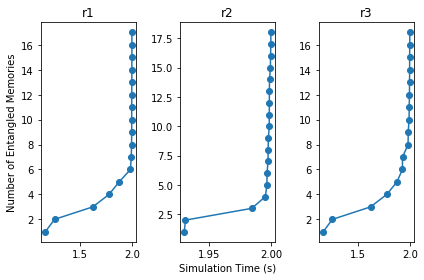

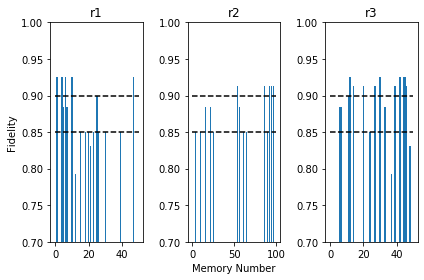

In [5]:
test(2000, 1000, 0.0002, 5)

### Results

We note that the number of entangled memories increses exponentially over time. This is due to memory expiration, with a coherence time of 0.3 seconds, as well as the consumption of memories for purification and swapping soon after they are entangled. We also see distinct layers of fidelities, reflecting the number of times an individual memory has been purified or swapped.